# Lab 3: Exploring Fairness When Training Models

In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline

import random
random.seed(6)

import sys
import warnings

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import GermanDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.postprocessing import EqOddsPostprocessing


## Step 1: Load the data

The German Credit Risk dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The original dataset can be found at https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29

### 1.1 Read in the aif360 dataset

In [2]:
dataset_orig = GermanDataset(protected_attribute_names=['age'],           
                             privileged_classes=[lambda x: x >= 25], 
                             features_to_drop=['personal_status', 'sex'])      # age >=25 is considered privileged

# Store definitions of priviledged and unpriviledged groups
privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

### 1.2 Split into train/val/test sets

In [3]:
# Split original data into train and test data
train_orig, test_orig = dataset_orig.split([0.8], shuffle=True, seed=10)
# Split training data in to training and validation data for hyperparameter tuning
train_orig, val_orig = train_orig.split([0.75], shuffle=True)

# Convert to dataframes
train_orig_df, _ = train_orig.convert_to_dataframe()
val_orig_df, _ = val_orig.convert_to_dataframe()
test_orig_df, _ = test_orig.convert_to_dataframe()

print("Train set: ", train_orig_df.shape)
print("Val set: ", val_orig_df.shape)
print("Test set: ", test_orig_df.shape)

Train set:  (600, 58)
Val set:  (200, 58)
Test set:  (200, 58)


In [4]:
print(train_orig_df.columns)
train_orig_df.head()

Index(['month', 'credit_amount', 'investment_as_income_percentage',
       'residence_since', 'age', 'number_of_credits', 'people_liable_for',
       'status=A11', 'status=A12', 'status=A13', 'status=A14',
       'credit_history=A30', 'credit_history=A31', 'credit_history=A32',
       'credit_history=A33', 'credit_history=A34', 'purpose=A40',
       'purpose=A41', 'purpose=A410', 'purpose=A42', 'purpose=A43',
       'purpose=A44', 'purpose=A45', 'purpose=A46', 'purpose=A48',
       'purpose=A49', 'savings=A61', 'savings=A62', 'savings=A63',
       'savings=A64', 'savings=A65', 'employment=A71', 'employment=A72',
       'employment=A73', 'employment=A74', 'employment=A75',
       'other_debtors=A101', 'other_debtors=A102', 'other_debtors=A103',
       'property=A121', 'property=A122', 'property=A123', 'property=A124',
       'installment_plans=A141', 'installment_plans=A142',
       'installment_plans=A143', 'housing=A151', 'housing=A152',
       'housing=A153', 'skill_level=A171', 'ski

,month,credit_amount,investment_as_income_percentage,residence_since,age,number_of_credits,people_liable_for,status=A11,status=A12,status=A13,...,housing=A153,skill_level=A171,skill_level=A172,skill_level=A173,skill_level=A174,telephone=A191,telephone=A192,foreign_worker=A201,foreign_worker=A202,credit
822,36.0,2712.0,2.0,2.0,1.0,1.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0
830,24.0,2375.0,4.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
703,30.0,2503.0,4.0,2.0,1.0,2.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
776,36.0,3535.0,4.0,4.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
659,18.0,6361.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0


As a reminder of what we did last week, let's calculate some fairness metrics on the training data.

In [5]:
train_orig_metrics = BinaryLabelDatasetMetric(train_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Mean difference = %f" % train_orig_metrics.mean_difference())
print("Disparate Impact = %f" % train_orig_metrics.disparate_impact())

Mean difference = -0.135481
Disparate Impact = 0.814721


## Step 2: Train a classifier to predict credit using the original data

We will be training a logistic regression model to predict good/bad credit, then fine-tuning the model over a set of hyperparameters. Then, we'll see how well this basic model does on some fairness metrics. 

### 2.1 Training and evaluationg a logistic regression model 
First, we need to split our data up into the explantory variables (x) and the outcome variable (y). We will recode the outcome so that the values are 0 (= bad credit) and 1 (= good credit). This is the format that the sklearn logistic regression function expects.

In [6]:
x_train = train_orig_df.drop("credit", axis=1)
y_train = train_orig_df.credit.replace({2:0}) 
print("Outcomes: ")
y_train.value_counts()

Outcomes: 


1.0    426
0.0    174
Name: credit, dtype: int64

Next, we can fit our model.

In [7]:
# Set up the logistic regression model with the given hyperparameters
initial_lr = LogisticRegression(C=0.5, penalty="l1", solver='liblinear')
    
# Fit the model using the training data
initial_lr = initial_lr.fit(x_train, y_train, sample_weight=None)

Now that we have a trained model, we should evaluate it on our validation set. For now, we'll look the AUC as well as accuracy when we use a cutoff of 0.5 (that is, predicted values over 0.5 are interpreted as good credit, and vice versa).

Let's write a funciton to do that, too.

In [8]:
def evaluate(model, X, y_true):
    '''Calculates the AUC and accuracy for a trained logistic regression model'''
    
    # Calculate predicted values
    y_pred = model.predict_proba(X)
    # This returns a tuple for each observation containing the probability of being in each class.
    # Since we're doing binary classification, all we need to know is the probability that the outcome = 1 (good credit)
    y_pred = [row[1] for row in y_pred] # This pulls the predicted probability that y = 1 for each observation

    # Calculate accuracy
    accuracy = accuracy_score(y_true, [pred_prob >= 0.5 for pred_prob in y_pred])
    
    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred)
    
    return accuracy, auc
    

In [9]:
# Before we call the function, we need to set up the validation data properly, the way we did for the training data.
x_val = val_orig_df.drop("credit", axis=1)
y_val = val_orig_df.credit.replace({2:0}) 

In [10]:
accuracy, auc = evaluate(initial_lr, x_val, y_val)
print("Accuracy: ", accuracy)
print("AUC: ", auc)

Accuracy:  0.73
AUC:  0.7853520462318669


### 2.2 Hyperparameter tuning the logistic regression model 

For hyperparameter tuning, we want to be able to easily train models with a variety of hyperparameter and determine which one performs the best on the validation data. We can use the functions we wrote above to do this. 

In [11]:
def tune_logistic_regression(train_df, val_df, penalty_types, C_values, weights=None, verbose=True):
    '''Tunes logistic regression models over the hyperparameters penalty type and C
       to maximize the AUC'''
    # Pre-process the training and validation data
    x_train = train_df.drop("credit", axis=1)
    y_train = train_df.credit.replace({2:0}) 
    x_val = val_df.drop("credit", axis=1)
    y_val = val_df.credit.replace({2:0}) 

    # Create empty lists where we will store the results of hyperparameter tuning 
    parameters = []
    models = []
    val_aucs = []
    
    # Loop through the hyperparameters of interest
    for penalty in penalty_types:
        for C in C_values:
            
            # Train the logistic regression model with the given hyperparameters
            lr = LogisticRegression(C=C, penalty=penalty, solver='liblinear')
    
            # Fit the model using the training data
            lr = lr.fit(x_train, y_train, sample_weight=weights)
            
            # Get the evalution metrics on the validation set 
            accuracy, auc  = evaluate(lr, x_val, y_val)
            
            # Store the results
            parameters.append({'penalty': penalty, 'C': C})
            models.append(lr)
            val_aucs.append(auc)
            
            # Print the results
            if verbose:
                print("\nParmeters: \tpenalty={} \tC={}".format(penalty, C))
                print("Validtion AUC: {}".format(auc))
            
    
    # Determine the best model -- that is, the one with the AUC
    best_model_index = np.argmax(val_aucs)
    best_model = models[best_model_index]
    
    print("\nBest model parameters: ", parameters[best_model_index])
    print("Best model AUC: ", val_aucs[best_model_index])
    
    # Return best model
    return best_model, parameters, models, val_aucs

In [12]:
best_lr, parameters, models, val_aucs = tune_logistic_regression(train_orig_df, val_orig_df, penalty_types=["l1", "l2"], C_values=[0.001, 0.1, 1, 10, 100, 1000, 10000, 100000])


Parmeters: 	penalty=l1 	C=0.001
Validtion AUC: 0.4036442976766128

Parmeters: 	penalty=l1 	C=0.1
Validtion AUC: 0.7456067932539214

Parmeters: 	penalty=l1 	C=1
Validtion AUC: 0.7699021110980069

Parmeters: 	penalty=l1 	C=10
Validtion AUC: 0.7450171010732397

Parmeters: 	penalty=l1 	C=100
Validtion AUC: 0.7410071942446043

Parmeters: 	penalty=l1 	C=1000
Validtion AUC: 0.741243071116877

Parmeters: 	penalty=l1 	C=10000
Validtion AUC: 0.7413610095530133

Parmeters: 	penalty=l1 	C=100000
Validtion AUC: 0.7411251326807408

Parmeters: 	penalty=l2 	C=0.001
Validtion AUC: 0.6545583205566695

Parmeters: 	penalty=l2 	C=0.1
Validtion AUC: 0.7965561976648191

Parmeters: 	penalty=l2 	C=1
Validtion AUC: 0.7690765420450525

Parmeters: 	penalty=l2 	C=10
Validtion AUC: 0.7648307583441443

Parmeters: 	penalty=l2 	C=100
Validtion AUC: 0.7653025120886896

Parmeters: 	penalty=l2 	C=1000
Validtion AUC: 0.7668357117584621

Parmeters: 	penalty=l2 	C=10000
Validtion AUC: 0.7648307583441444

Parmeters: 	penalt

Let's plot the results so that we understand what hyperparameter tuning actually did.

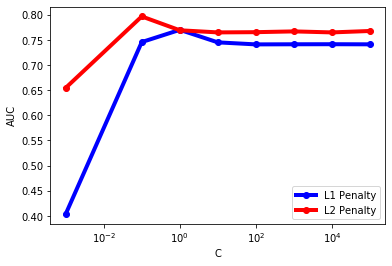

In [13]:
val_aucs_l1 = [val_aucs[i] for i in range(len(val_aucs)) if parameters[i]['penalty']=="l1"]
val_aucs_l2 = [val_aucs[i] for i in range(len(val_aucs)) if parameters[i]['penalty']=="l2"]
C_values = [parameters[i]['C'] for i in range(len(parameters)) if parameters[i]['penalty']=="l2"]

fig, ax = plt.subplots()
ax.semilogx( C_values, val_aucs_l1, marker='.', markerfacecolor='blue', markersize=12, color='blue', linewidth=4, label='L1 Penalty')
ax.semilogx( C_values, val_aucs_l2, marker='.', markerfacecolor='red', markersize=12, color='red', linewidth=4, label='L2 Penalty')
ax.set_xlabel("C")
ax.set_ylabel("AUC")
plt.legend()
plt.show()

### 2.3 Evaluating bias in our predictions

Let's put our data back into a aif360 dataset format, so that we can use all of the fairness metrics provided by the package. For now, we'll evaluate bias on the training data. This mimics the development process we'd use in any real application.

First, we'll get predicted values using the best model and attach them as a new column in the data frame. We'll use 0.5 as the threshold as before.

In [14]:
# Copy the dataset
train_preds_df = train_orig_df.copy()
# Calculate predicted values
train_preds_df['credit'] = best_lr.predict(x_train)
# Recode the predictions so that they match the format that the dataset was originally provided in 
# (1 = good credit, 2 = bad credit)
train_preds_df['credit'] = train_preds_df.credit.replace({0:2})

Then we'll create an object of the aif360 StandardDataset class. You can read more about this in the documentation:
https://aif360.readthedocs.io/en/latest/modules/standard_datasets.html#aif360.datasets.StandardDataset

In [15]:
orig_aif360 = StandardDataset(train_orig_df, label_name='credit', protected_attribute_names=['age'], 
                privileged_classes=[[1]], favorable_classes=[1])
preds_aif360 = StandardDataset(train_preds_df, label_name='credit', protected_attribute_names=['age'], 
                privileged_classes=[[1]], favorable_classes=[1])

Now, let's calculate some fairness metrics!

In [16]:
pred_metrics = BinaryLabelDatasetMetric(preds_aif360, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Mean difference = %f" % pred_metrics.mean_difference())
print("Disparate Impact = %f" % pred_metrics.disparate_impact())


Mean difference = -0.221386
Disparate Impact = 0.742480


Recall from last week that we identified bias in the training data. We should therefore not find it surprising that we have bias in a model trained on that data.

Now, since we have true values and predicted values, let's compare the true positive rate and false positive rate by group. This is similar to the analysis ProPublica did. 

Note that aif360 is pretty picky about what goes into this ClassificationMetric class, which is the reason for all the inefficient copying of datasets above. 

In [17]:
orig_vs_preds_metrics = ClassificationMetric(orig_aif360, preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privledged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivledged groups = %f" % orig_vs_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privledged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivledged groups = %f" % orig_vs_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_metrics.false_positive_rate_ratio())





Error rate difference (unprivileged error rate - privileged error rate)= 0.090362

False negative rate for privledged groups = 0.054054
False negative rate for unprivledged groups = 0.214286
False negative rate ratio = 3.964286

False positive rate for privledged groups = 0.625000
False positive rate for unprivledged groups = 0.421053
False positive rate ratio = 0.673684


This confirms it: our model is even *more* biased than the original credit scores.  

Let's try to fix that.

## Step 3: Train a classifier to predict credit using the original data, excluding the sensitive feature

We've talked several times in class about how removing a sensitive attribute is not enough. Let's see if that's true in action.

In [18]:
best_lr_noage, _, _, _ = tune_logistic_regression(train_orig_df.drop('age', axis=1), val_orig_df.drop('age', axis=1),
                                                                       penalty_types=["l1", "l2"], C_values=[0.001, 0.1, 1, 10, 100, 1000, 10000, 100000], verbose=False)



Best model parameters:  {'penalty': 'l2', 'C': 0.1}
Best model AUC:  0.7816959547116406


Note that the AUC of our best model is *slightly* worse than before: by excluding a feature, we've lost some predictive power.

Now let's check the same bias metrics again.

In [19]:
preds_df_noage = train_orig_df.copy()
preds_df_noage['credit'] = best_lr_noage.predict(x_train.drop('age', axis=1))
preds_df_noage['credit'] = preds_df_noage.credit.replace({0:2})

In [20]:
noage_preds_aif360 = StandardDataset(preds_df_noage, label_name='credit', protected_attribute_names=['age'], 
                privileged_classes=[[1]], favorable_classes=[1])


noage_preds_metrics = BinaryLabelDatasetMetric(noage_preds_aif360, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Mean difference = %f" % noage_preds_metrics.mean_difference())
print("Disparate Impact = %f" % noage_preds_metrics.disparate_impact())

orig_vs_noage_preds_metrics = ClassificationMetric(orig_aif360, noage_preds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_noage_preds_metrics.error_rate_difference())


print("\nFalse negative rate for privledged groups = %f" % orig_vs_noage_preds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivledged groups = %f" % orig_vs_noage_preds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_noage_preds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privledged groups = %f" % orig_vs_noage_preds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivledged groups = %f" % orig_vs_noage_preds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_noage_preds_metrics.false_positive_rate_ratio())



Mean difference = -0.156337
Disparate Impact = 0.815603

Error rate difference (unprivileged error rate - privileged error rate)= 0.079724

False negative rate for privledged groups = 0.062162
False negative rate for unprivledged groups = 0.160714
False negative rate ratio = 2.585404

False positive rate for privledged groups = 0.602941
False positive rate for unprivledged groups = 0.473684
False positive rate ratio = 0.785623


Scroll up -- how do these numbers for our model that doesn't use age compare to the model that *does* use it?

Which figures are encoding the same information as age?

In [21]:
# Your code here

## Step 3: Preprocess the data using the reweighting algorithm, then train a classifier to predict credit using the re-weighted data

In [22]:
# Fit the weights to our training data
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
RW_fit = RW.fit(train_orig)


In [23]:
# Pull the actual values of the weights for the training data
train_reweighed = RW_fit.transform(train_orig)
training_weights = train_reweighed.instance_weights
training_weights

array([1.07897059, 0.97097297, 0.97097297, 0.97097297, 0.97097297,
       0.71736842, 1.07897059, 0.97097297, 1.19178571, 0.97097297,
       0.97097297, 0.71736842, 1.07897059, 0.97097297, 0.97097297,
       0.97097297, 1.07897059, 0.97097297, 1.07897059, 0.97097297,
       1.19178571, 0.97097297, 0.97097297, 1.07897059, 1.19178571,
       0.71736842, 0.97097297, 1.19178571, 1.07897059, 0.97097297,
       0.97097297, 0.97097297, 0.97097297, 0.97097297, 0.97097297,
       0.97097297, 0.97097297, 0.97097297, 1.07897059, 1.19178571,
       0.97097297, 1.07897059, 0.97097297, 0.97097297, 0.97097297,
       0.97097297, 0.97097297, 0.97097297, 0.97097297, 1.07897059,
       0.97097297, 0.97097297, 1.07897059, 0.97097297, 1.19178571,
       0.97097297, 0.97097297, 1.19178571, 0.97097297, 0.97097297,
       0.97097297, 1.19178571, 0.97097297, 1.07897059, 0.97097297,
       0.97097297, 0.97097297, 0.71736842, 0.97097297, 0.97097297,
       0.97097297, 0.97097297, 0.97097297, 0.97097297, 1.19178

In [24]:
# Train a model using weights
best_lr_weights, _, _, _ = tune_logistic_regression(train_orig_df.drop('age', axis=1), val_orig_df.drop('age', axis=1),
                                                                       penalty_types=["l1", "l2"], C_values=[0.001, 0.1, 1, 10, 100, 1000, 10000, 100000], 
                                                                       weights=training_weights, verbose=False)


Best model parameters:  {'penalty': 'l2', 'C': 0.1}
Best model AUC:  0.775209340724142


Hey look-- our AUC fell again. As we've discussed, there's often a tradeoff between fairness and other metrics that stakeholders care about. 

Let's see if the fairness metrics changed. 

In [25]:
train_preds_df_weights = train_orig_df.copy()
train_preds_df_weights['credit'] = best_lr_weights.predict(x_train.drop('age', axis=1))
train_preds_df_weights['credit'] = train_preds_df_weights.credit.replace({0:2})

In [26]:
preds_weights_aif360 = StandardDataset(train_preds_df_weights, label_name='credit', protected_attribute_names=['age'], 
                privileged_classes=[[1]], favorable_classes=[1])
preds_weights_metrics = BinaryLabelDatasetMetric(preds_weights_aif360, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Mean difference = %f" % preds_weights_metrics.mean_difference())
print("Disparate Impact = %f" % preds_weights_metrics.disparate_impact())

orig_vs_preds_weights_metrics = ClassificationMetric(orig_aif360, preds_weights_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_weights_metrics.error_rate_difference())

print("\nFalse negative rate for privledged groups = %f" % orig_vs_preds_weights_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivledged groups = %f" % orig_vs_preds_weights_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_weights_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privledged groups = %f" % orig_vs_preds_weights_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivledged groups = %f" % orig_vs_preds_weights_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_weights_metrics.false_positive_rate_ratio())



Mean difference = -0.079892
Disparate Impact = 0.905548

Error rate difference (unprivileged error rate - privileged error rate)= 0.067110

False negative rate for privledged groups = 0.064865
False negative rate for unprivledged groups = 0.089286
False negative rate ratio = 1.376488

False positive rate for privledged groups = 0.602941
False positive rate for unprivledged groups = 0.552632
False positive rate ratio = 0.916560


How do these numbers compare to the numbers above?

## Step 4: Post-process the predictions from the model that we trained using weights by using the calibrated equality of odds algorithm 

The equality of odds algorithm is a method for adjusting predicted prbabilities to ensure that the false negative rate is equal for the privilged and unprivilged groups. (This also ensures that the true positive rate is equal.) To do so, the algorithm uses the predicted probabilities and determines *two* threshold probabilitties for each group. Above the upper threshold, all members of the group are assigned to the positive class, and below the lower threshold, all members of the group are assigned to the negative class. But between the two thresholds, individuals are randomly assigned a class. 

For details, see M. Hardt, E. Price, and N. Srebro, “Equality of Opportunity in Supervised Learning,” Conference on Neural Information Processing Systems, 2016.

Which definitions of fairness does this post-processing algorithm contradict?

In [27]:
# Transform our predictions using the aif360 implementation of the equality of odds algorithm
eq_odds = EqOddsPostprocessing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, seed=47)
preds_weights_eq_odds_aif360 = eq_odds.fit_predict(orig_aif360, preds_weights_aif360)

In [28]:
# Calculate fairness metrics
preds_weights_eq_odds_metrics = BinaryLabelDatasetMetric(preds_weights_eq_odds_aif360, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Mean difference = %f" % preds_weights_eq_odds_metrics.mean_difference())
print("Disparate Impact = %f" % preds_weights_eq_odds_metrics.disparate_impact())

orig_vs_preds_weights_eq_odds_metrics = ClassificationMetric(orig_aif360, preds_weights_eq_odds_aif360,
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)

print("\nError rate difference (unprivileged error rate - privileged error rate)= %f" % orig_vs_preds_weights_eq_odds_metrics.error_rate_difference())

print("\nFalse negative rate for privledged groups = %f" % orig_vs_preds_weights_eq_odds_metrics.false_negative_rate(privileged=True))
print("False negative rate for unprivledged groups = %f" % orig_vs_preds_weights_eq_odds_metrics.false_negative_rate(privileged=False))
print("False negative rate ratio = %f" % orig_vs_preds_weights_eq_odds_metrics.false_negative_rate_ratio())


print("\nFalse positive rate for privledged groups = %f" % orig_vs_preds_weights_eq_odds_metrics.false_positive_rate(privileged=True))
print("False positive rate for unprivledged groups = %f" % orig_vs_preds_weights_eq_odds_metrics.false_positive_rate(privileged=False))
print("False positive rate ratio = %f" % orig_vs_preds_weights_eq_odds_metrics.false_positive_rate_ratio())


Mean difference = 0.008662
Disparate Impact = 5.382979

Error rate difference (unprivileged error rate - privileged error rate)= -0.126819

False negative rate for privledged groups = 1.000000
False negative rate for unprivledged groups = 1.000000
False negative rate ratio = 1.000000

False positive rate for privledged groups = 0.007353
False positive rate for unprivledged groups = 0.026316
False positive rate ratio = 3.578947


What's changed in these metrics? How could the algorithm have caused that? 

In [29]:
# Test how accuracy has changed
print("\nAccuracy (on training data) before equality of odds algorithm = %f" % orig_vs_preds_weights_metrics.accuracy())
print("\nAccuracy (on training data) after equality of odds algorithm = %f" % orig_vs_preds_weights_eq_odds_metrics.accuracy())


Accuracy (on training data) before equality of odds algorithm = 0.780000

Accuracy (on training data) after equality of odds algorithm = 0.286667
